In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt
%matplotlib inline 

In [60]:
# config
use_languages = False
aggregate_sub_questions = True
na_threshold = 0.1
filter_columns = True

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

/Users/shuangziguo/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (12,49,51,56,91,126,145,163,165,166,167,168,169,171,173,174,176,177,242,244,246,248,252,255,274,290,291,292,294,295,296,332,344,366,374,376,397,414,440,491,620,634,639,642,643,645,710,713,760,769,810,829,929,954,979,1001,1002,1003,1004,1005,1024,1037,1041,1043,1062,1086,1099,1100,1121,1129,1136,1152,1153,1166,1168,1182,1193,1204,1205,1207,1208,1216,1226,1228,1230,1232,1234) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/shuangziguo/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11,13,48,50,55,90,125,144,162,163,164,166,168,169,170,171,172,174,176,241,243,245,247,251,254,273,289,291,292,293,295,296,312,313,314,331,343,365,373,375,396,413,439,490,619,623,630,633,638,642,644,669,712,759,768,788,809,828,928,953,978,1000,10

### Read in code book

In [4]:
# get descriptions for columns
desc = pd.read_csv('WiDS_data_dictionary/Codebook-Table 1.csv')

In [5]:
# make dictionary of column name to description to use later on
desc = desc.assign(ColumnName2=desc['Column Name'].apply(lambda x: str(x).replace('_', '.')))
desc = desc.assign(Description=desc.apply(lambda x: str(x['Question']).split(x['ColumnName2'], 1)[-1], axis=1))
desc = desc.assign(Description=desc.Description.apply(lambda x: x[1:] if len(x) > 1 and x[0] == '.' else x))
desc_dict = pd.Series(desc['Description'].values, index=desc['Column Name'].values).to_dict()

In [6]:
# filter out main question category
desc = desc.assign(MainQuestion=desc['Column Name'].apply(lambda x: str(x).split('_')[0]))

### Basic manipulation of train and test dataset

In [8]:
train.shape

(18255, 1235)

In [9]:
test.shape

(27285, 1234)

In [10]:
# sum up non-NaN values per column
num_not_nan_train = train.apply(lambda x: sum(~pd.isnull(x)), axis=0)
num_not_nan_test = test.apply(lambda x: sum(~pd.isnull(x)), axis=0)

In [11]:
sum(num_not_nan_test == 0)

31

In [12]:
sum(num_not_nan_train == 0)

50

In [13]:
# filter out columns with no data
nan_train_columns = list(num_not_nan_train[num_not_nan_train == 0].index)
nan_test_columns = list(num_not_nan_test[num_not_nan_test == 0].index)
train = train.drop(nan_train_columns, axis=1)
test = test.drop(nan_test_columns, axis=1)

In [14]:
# filter for common columns
common_cols = list(set(train.columns).intersection(test.columns))

In [16]:
train = train[common_cols + ['train_id', 'is_female']]
test = test[common_cols + ['test_id']]

### Sum up answers in the same question group

In [18]:
num_sub_questions = desc[['MainQuestion', 'Column Name']].groupby('MainQuestion').count()

In [19]:
mult_sub_questions = num_sub_questions[num_sub_questions['Column Name'] > 1]

In [20]:
mult_sub_questions.sort_values('Column Name', ascending=False)

,Column Name
MainQuestion,
DL4,25
FF16,24
IFI10,24
IFI11,24
IFI12,24
FF14,24
MM17,24
MM15,24
MM40,19


In [21]:
# aggregate columns with more than 3 sub questions
mult_sub_questions = mult_sub_questions[mult_sub_questions['Column Name'] > 15]

In [22]:
if aggregate_sub_questions:
    for col in mult_sub_questions['Column Name'].index:
        sub_questions = desc.loc[desc['MainQuestion'] == col, 'Column Name']
        # have to write this properly, right now it seems to work on looking for last sub column
        if sub_questions.iloc[-1] in train.columns:
            train[col] = train[sub_questions].sum(axis=1)
            train = train.drop(sub_questions, axis=1)
        if sub_questions.iloc[-1] in test.columns:    
            test[col] = test[sub_questions].sum(axis=1)
            test = test.drop(sub_questions, axis=1)

In [24]:
sub_train = train.dropna(thresh=na_threshold*len(train), axis=1)
sub_train.shape

(18255, 443)

### Transform language columns 

In [26]:
# transform languages in training set, split up multiple languages into separate columns
# lang_cols = ['language_1', 'language_2', 'language_3','language_4']
df1 = sub_train.LN2_RIndLngBEOth.str.split('&', expand=True)
df1.columns = ['language_1', 'language_2']
df2 = sub_train.LN2_WIndLngBEOth.str.split('&', expand=True)
df2.columns = ['language_3','language_4']
ext_train = pd.concat([sub_train, df1, df2], axis=1)

In [27]:
# transform languages for test set
df1 = test.LN2_RIndLngBEOth.str.split('&', expand=True)
df1.columns = ['language_1', 'language_2']
df2 = test.LN2_WIndLngBEOth.str.split('&', expand=True)
df2.columns = ['language_3','language_4']
ext_test = pd.concat([test, df1, df2], axis=1)

In [28]:
if use_languages:
    train_to_use = ext_train
else:
    train_to_use = sub_train
train_variables = train_to_use.drop(['is_female', 'train_id', 'LN2_RIndLngBEOth', 'LN2_WIndLngBEOth'], axis=1)
target = train_to_use['is_female'].values
test_variables = ext_test[train_variables.columns]

### Measure disparity

In [31]:
def get_disparity(data, value_col, split_col):
    col_hist = data[['train_id', value_col, split_col]].groupby([value_col, split_col]).count()
    col_hist = col_hist.reset_index()
    col_hist = col_hist[[value_col, 'train_id']].groupby(value_col).apply(lambda x: max(x['train_id']) - min(x['train_id']))
    return col_hist

In [32]:
disparities = pd.DataFrame()
for col in train_variables.columns:
    col_hist = get_disparity(train_to_use, col, 'is_female')
    question = desc_dict[col] if col in desc_dict.keys() else col
    col_df = pd.DataFrame({'Question': question, 'Answer': col_hist.index, 'Disparity': col_hist.values, 'Column': col})
    disparities = disparities.append(col_df)

In [33]:
disparities.sort_values('Disparity', ascending=False).head(10)

,Answer,Column,Disparity,Question
1,2.0,DL0,6340,Who is the main income earner in your household?
1,2.0,DG6,5893,How are you related to the household head?
6,7.0,DL1,5398,"In the past 12 months, were you mainly...?"
0,1.0,DL0,4985,Who is the main income earner in your household?
1,2.0,MT1A,4745,Who decides on who should have a phone in your...
0,1.0,DG6,4295,How are you related to the household head?
1,2.0,FL4,3962,What or who do you depend on the most for fina...
0,1.0,MT1A,3961,Who decides on who should have a phone in your...
1,2.0,MT10,3943,Do you personally have an active/working SIM c...
0,1.0,MT6,3785,How did you obtain your phone?


In [34]:
disp_by_col = disparities[['Column', 'Question', 'Disparity']].groupby(['Column', 'Question']).sum()
disp_by_col = disp_by_col.reset_index()

In [35]:
disp_col = disp_by_col.sort_values('Disparity', ascending=False)['Column'].values
low_disp_col = disp_by_col.loc[disp_by_col.Disparity < 500, 'Column'].values
len(low_disp_col)

53

In [36]:
desc[desc['Column Name'].isin(list(low_disp_col))]

,Column Name,Question,Values,Unnamed: 3,Unnamed: 4,ColumnName2,Description,MainQuestion
2,AA5,AA5. Town Class,1=Town Class 1\n2=Town Class 2\n3=Town Class 3...,NaN,NaN,AA5,Town Class,AA5
30,DG13_1,DG13.1. Have you ever experienced the followin...,1=Yes\n2=No,NaN,NaN,DG13.1,Have you ever experienced the following probl...,DG13
31,DG13_2,DG13.2. Have you ever experienced the followin...,1=Yes\n2=No,NaN,NaN,DG13.2,Have you ever experienced the following probl...,DG13
32,DG13_3,DG13.3. Have you ever experienced the followin...,1=Yes\n2=No,NaN,NaN,DG13.3,Have you ever experienced the following probl...,DG13
33,DG13_4,DG13.4. Have you ever experienced the followin...,1=Yes\n2=No,NaN,NaN,DG13.4,Have you ever experienced the following probl...,DG13
34,DG13_5,DG13.5. Have you ever experienced the followin...,1=Yes\n2=No,NaN,NaN,DG13.5,Have you ever experienced the following probl...,DG13
35,DG13_96,DG13.96. Have you ever experienced the followi...,1=Yes\n2=No,NaN,NaN,DG13.96,Have you ever experienced the following probl...,DG13
36,DG13_7,DG13.7. Have you ever experienced the followin...,1=Yes\n2=No,NaN,NaN,DG13.7,Have you ever experienced the following probl...,DG13
70,DL12,DL12.What was the main reason you moved?,"1=Natural disaster (hurricane, earthquake or f...",NaN,NaN,DL12,What was the main reason you moved?,DL12
102,DL27,DL27.Which of these events made the biggest im...,"1=Flood, fire or other natural disaster destro...",NaN,NaN,DL27,Which of these events made the biggest impact ...,DL27


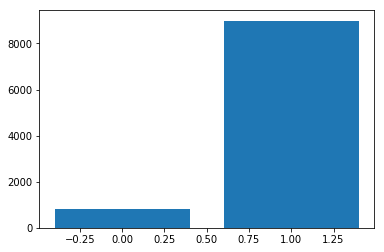

In [37]:
col = disp_col[0]
cat_variables = desc_dict.keys()
if col in cat_variables:
    col_hist = sub_train[[col, 'is_female', 'train_id']].groupby([col, 'is_female']).count()
    col_hist = col_hist.reset_index()
    y = col_hist.loc[col_hist['is_female'] == 1, 'train_id']
    plt.bar(range(len(y)), y)
else:      
    plt.hist(train_variables[target == 1][col], align='left')
    plt.hist(train_variables[target == 0][col], align='right')
    plt.title(col)

In [38]:
desc.head(5)

,Column Name,Question,Values,Unnamed: 3,Unnamed: 4,ColumnName2,Description,MainQuestion
0,is_female,DG2. Is the respondent a male or a female?,1=Male\n2=Female,NaN,NaN,is.female,DG2. Is the respondent a male or a female?,is
1,AA3,AA3. Zone,1=North\n2=East\n3=West\n4=South,NaN,NaN,AA3,Zone,AA3
2,AA5,AA5. Town Class,1=Town Class 1\n2=Town Class 2\n3=Town Class 3...,NaN,NaN,AA5,Town Class,AA5
3,AA6,AA6. Village Class,6=Village Class 1\n7=Village Class 2\n8=Villag...,NaN,NaN,AA6,Village Class,AA6
4,AA8,AA8. Town Selection,1=Original\n2=Replacement 1\n3=Replacement 2\n...,NaN,NaN,AA8,Town Selection,AA8


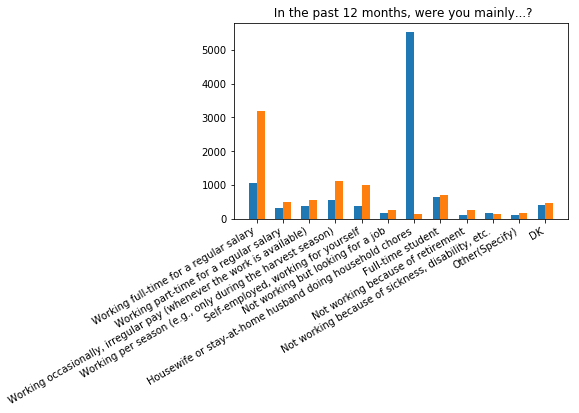

In [39]:
col = disp_col[2]
col_hist = sub_train[[col, 'is_female', 'train_id']].groupby([col, 'is_female']).count()
col_hist = col_hist.reset_index()
answers = desc.loc[desc['Column Name'] == col, 'Values'].iloc[0].split('\n')
answer_dict = {}
[answer_dict.update({x.split('=')[0]: x.split('=')[1]}) for x in answers]
col_hist = col_hist.assign(AnswerDesc=col_hist[col].apply(lambda x: answer_dict[str(x)]))
num_answers = len(answer_dict)
ticks = np.arange(num_answers) + 0.5
fig, ax = plt.subplots()
ax.bar(ticks-0.3, col_hist.loc[col_hist['is_female'] == 1, 'train_id'], width=0.3, align='edge')
ax.bar(ticks, col_hist.loc[col_hist['is_female'] == 0, 'train_id'], width=0.3, align='edge')
ax.set_xticks(ticks)
ax.set_xticklabels(col_hist.loc[col_hist['is_female'] == 0, 'AnswerDesc'])
plt.title(desc_dict[col])
fig.autofmt_xdate()

### Filter out columns with low disparity

In [40]:
filt_cols = [x for x in train_variables.columns if x not in low_disp_col]
filt_train = train_variables[filt_cols]
filt_test = ext_test[filt_cols]

### Convert train and test set together

In [61]:
if filter_columns:
    train_test = pd.concat((filt_train, filt_test)) 
else:
    train_test = pd.concat((train_variables, test_variables))

In [62]:
desc = desc.assign(NumVariables=desc.Values.apply(lambda x: str(x).count('\n')+1))
var_to_dummies = desc[desc.NumVariables > 2].iloc[:, 0].values
sub_var_to_dummies = list(set(list(var_to_dummies)).intersection(train_test.columns))

In [63]:
new_train_test = pd.get_dummies(train_test, columns=sub_var_to_dummies).values

In [64]:
new_train = new_train_test[0:len(train)]
new_test = new_train_test[len(train):len(train)+len(test)]

### Fit XGboost model

In [70]:
xgtrain = xgb.DMatrix(new_train, target)

In [65]:
n_folds = 5
early_stopping = 10
params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.4, 'objective': 'binary:logistic', 'seed': 99, 'silent': 1, 'eval_metric':'auc', 'nthread':4}
bst = xgb.train(params, xgtrain)
bst.cv = xgb.cv(params, xgtrain, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

[0]	train-auc:0.948141+0.000970195	test-auc:0.930013+0.00295984
[1]	train-auc:0.9641+0.00281808	test-auc:0.946984+0.00544005
[2]	train-auc:0.968829+0.00179371	test-auc:0.95127+0.00357323
[3]	train-auc:0.972789+0.000778982	test-auc:0.955415+0.00235338
[4]	train-auc:0.974019+0.00101028	test-auc:0.956069+0.00387127
[5]	train-auc:0.975179+0.000757975	test-auc:0.956762+0.00406077
[6]	train-auc:0.975875+0.000484089	test-auc:0.958167+0.00357854
[7]	train-auc:0.976805+0.000827733	test-auc:0.958931+0.00380342
[8]	train-auc:0.977646+0.000595485	test-auc:0.960187+0.00323447
[9]	train-auc:0.977918+0.000754616	test-auc:0.960444+0.00359168
[10]	train-auc:0.978349+0.00052586	test-auc:0.961013+0.00294272
[11]	train-auc:0.978781+0.00056985	test-auc:0.961548+0.00258823
[12]	train-auc:0.97922+0.000513983	test-auc:0.961863+0.00272369
[13]	train-auc:0.979676+0.00051636	test-auc:0.962182+0.0026896
[14]	train-auc:0.980041+0.000484401	test-auc:0.962479+0.00291186
[15]	train-auc:0.980239+0.000391186	test-auc:0

[127]	train-auc:0.987177+0.000326013	test-auc:0.967069+0.00127581
[128]	train-auc:0.987204+0.000308162	test-auc:0.967087+0.00127168
[129]	train-auc:0.987239+0.00030646	test-auc:0.967096+0.00124994
[130]	train-auc:0.987277+0.000318115	test-auc:0.967116+0.00127528
[131]	train-auc:0.987331+0.000331786	test-auc:0.967116+0.00129299
[132]	train-auc:0.987387+0.000320542	test-auc:0.967144+0.00132356
[133]	train-auc:0.987442+0.000322503	test-auc:0.967165+0.00133686
[134]	train-auc:0.987487+0.000314246	test-auc:0.967174+0.0013362
[135]	train-auc:0.98753+0.000327541	test-auc:0.967171+0.00132816
[136]	train-auc:0.987574+0.000334606	test-auc:0.96717+0.00132868
[137]	train-auc:0.987638+0.000328545	test-auc:0.9672+0.00130848
[138]	train-auc:0.987689+0.000310728	test-auc:0.967205+0.00131921
[139]	train-auc:0.987715+0.000315847	test-auc:0.967209+0.00132311
[140]	train-auc:0.987758+0.000321982	test-auc:0.967234+0.00130593
[141]	train-auc:0.987786+0.000326783	test-auc:0.967237+0.001298
[142]	train-auc:0.

[252]	train-auc:0.99172+0.000204166	test-auc:0.968801+0.00116552
[253]	train-auc:0.991744+0.000205318	test-auc:0.968815+0.00115583
[254]	train-auc:0.991772+0.000202418	test-auc:0.96882+0.00116056
[255]	train-auc:0.991805+0.000204896	test-auc:0.968839+0.00115327
[256]	train-auc:0.991835+0.000201219	test-auc:0.968848+0.00113228
[257]	train-auc:0.991868+0.000200037	test-auc:0.968854+0.00113347
[258]	train-auc:0.991896+0.000195156	test-auc:0.968867+0.00112852
[259]	train-auc:0.991926+0.000188784	test-auc:0.968863+0.00112243
[260]	train-auc:0.991954+0.00018807	test-auc:0.968885+0.00112119
[261]	train-auc:0.991984+0.000188115	test-auc:0.968904+0.00111395
[262]	train-auc:0.992016+0.00018711	test-auc:0.968913+0.00111407
[263]	train-auc:0.992041+0.000187681	test-auc:0.968924+0.00111293
[264]	train-auc:0.992071+0.000187861	test-auc:0.968936+0.00111776
[265]	train-auc:0.9921+0.000185251	test-auc:0.968949+0.0011345
[266]	train-auc:0.992132+0.000188207	test-auc:0.968953+0.00112822
[267]	train-auc:0

[377]	train-auc:0.994831+0.000141843	test-auc:0.970013+0.00106227
[378]	train-auc:0.994848+0.0001416	test-auc:0.970021+0.00106546
[379]	train-auc:0.99487+0.00013655	test-auc:0.970033+0.00106276
[380]	train-auc:0.99489+0.000140595	test-auc:0.970036+0.00106572
[381]	train-auc:0.994911+0.000137006	test-auc:0.970045+0.00105769
[382]	train-auc:0.994932+0.000135885	test-auc:0.970049+0.00106318
[383]	train-auc:0.994958+0.000135287	test-auc:0.970052+0.00106157
[384]	train-auc:0.994977+0.000135278	test-auc:0.970052+0.00106948
[385]	train-auc:0.994999+0.000134856	test-auc:0.970059+0.00106878
[386]	train-auc:0.99502+0.000136497	test-auc:0.970074+0.00106642
[387]	train-auc:0.995034+0.000131943	test-auc:0.970081+0.001065
[388]	train-auc:0.995053+0.000135417	test-auc:0.970105+0.00106907
[389]	train-auc:0.995071+0.000135101	test-auc:0.97011+0.0010654
[390]	train-auc:0.995088+0.000132361	test-auc:0.97012+0.00106412
[391]	train-auc:0.995109+0.00012683	test-auc:0.970127+0.00106616
[392]	train-auc:0.9951

[503]	train-auc:0.996853+3.95242e-05	test-auc:0.970839+0.00103975
[504]	train-auc:0.996867+3.87835e-05	test-auc:0.970849+0.00103571
[505]	train-auc:0.996877+4.0936e-05	test-auc:0.970855+0.00102885
[506]	train-auc:0.996888+4.11261e-05	test-auc:0.970862+0.00102814
[507]	train-auc:0.996899+3.93985e-05	test-auc:0.970863+0.0010247
[508]	train-auc:0.996911+3.92805e-05	test-auc:0.970865+0.00102583
[509]	train-auc:0.996925+4.04702e-05	test-auc:0.970871+0.00102254
[510]	train-auc:0.996937+4.12572e-05	test-auc:0.970875+0.00101755
[511]	train-auc:0.996946+4.36165e-05	test-auc:0.970886+0.00101445
[512]	train-auc:0.996957+4.14169e-05	test-auc:0.970889+0.00100391
[513]	train-auc:0.996967+4.16538e-05	test-auc:0.97089+0.000998781
[514]	train-auc:0.996979+4.08872e-05	test-auc:0.9709+0.000998381
[515]	train-auc:0.99699+4.22914e-05	test-auc:0.97091+0.00099467
[516]	train-auc:0.997+3.95039e-05	test-auc:0.970915+0.000989274
[517]	train-auc:0.997014+3.70005e-05	test-auc:0.970919+0.000983721
[518]	train-auc:

[627]	train-auc:0.998061+1.91771e-05	test-auc:0.971396+0.000977516
[628]	train-auc:0.998069+2.06785e-05	test-auc:0.971406+0.000981264
[629]	train-auc:0.998077+2.23553e-05	test-auc:0.971412+0.000977833
[630]	train-auc:0.998087+2.3821e-05	test-auc:0.971416+0.000985764
[631]	train-auc:0.998093+2.58643e-05	test-auc:0.971418+0.000986619
[632]	train-auc:0.9981+2.61182e-05	test-auc:0.97142+0.000987073
[633]	train-auc:0.998106+2.65737e-05	test-auc:0.971423+0.000987688
[634]	train-auc:0.998114+2.62191e-05	test-auc:0.971432+0.000988695
[635]	train-auc:0.998122+2.57418e-05	test-auc:0.971433+0.000993953
[636]	train-auc:0.998129+2.63257e-05	test-auc:0.971436+0.000995004
[637]	train-auc:0.998135+2.50152e-05	test-auc:0.971443+0.000990464
[638]	train-auc:0.998142+2.44671e-05	test-auc:0.971448+0.000985676
[639]	train-auc:0.998149+2.39533e-05	test-auc:0.971452+0.000982892
[640]	train-auc:0.998156+2.49608e-05	test-auc:0.971452+0.000978584
[641]	train-auc:0.998163+2.41777e-05	test-auc:0.971449+0.000977869

[750]	train-auc:0.99883+2.39867e-05	test-auc:0.971699+0.000918118
[751]	train-auc:0.998834+2.35678e-05	test-auc:0.9717+0.00091455
[752]	train-auc:0.998838+2.46949e-05	test-auc:0.971706+0.000911209
[753]	train-auc:0.998844+2.64605e-05	test-auc:0.97171+0.000909447
[754]	train-auc:0.998848+2.62496e-05	test-auc:0.971714+0.000914437
[755]	train-auc:0.998853+2.59183e-05	test-auc:0.971716+0.000909334
[756]	train-auc:0.998857+2.62496e-05	test-auc:0.971723+0.000910045
[757]	train-auc:0.998861+2.75071e-05	test-auc:0.971714+0.000913722
[758]	train-auc:0.998866+2.7222e-05	test-auc:0.971717+0.000915767
[759]	train-auc:0.998872+2.77892e-05	test-auc:0.971725+0.000917374
[760]	train-auc:0.998877+2.73013e-05	test-auc:0.971729+0.00091654
[761]	train-auc:0.998881+2.59044e-05	test-auc:0.971735+0.000913163
[762]	train-auc:0.998888+2.61733e-05	test-auc:0.971742+0.000912569
[763]	train-auc:0.998892+2.69474e-05	test-auc:0.971746+0.000910844
[764]	train-auc:0.998897+2.73013e-05	test-auc:0.97175+0.000907477
[76

In [71]:
params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.5, 'objective': 'binary:logistic', 
          'seed': 10, 'silent': 0, 'eval_metric':'auc', 'nthread': 4}
bst = xgb.train(params, xgtrain, num_boost_round=850)

### Predict for train set

In [72]:
xg_train2 = xgb.DMatrix(new_train)

In [73]:
predicted_train = bst.predict(xg_train2)
predicted_train

array([0.7519793 , 0.995135  , 0.99397886, ..., 0.01049043, 0.01183765,
       0.99277556], dtype=float32)

In [75]:
100. * sum(abs(predicted_train - target)) / len(target)

7.026137881949916

### Predict for test set

In [77]:
xg_test = xgb.DMatrix(new_test)
predicted_test = bst.predict(xg_test)

In [78]:
predicted_df = pd.DataFrame({'test_id': test['test_id'].values, 'is_female': list(predicted_test)})
predicted_df.to_csv('0.1_10_0.5_agg_filt_submission.csv', index=False)